In [1]:
using PyPlot, SeisReconstruction, LinearAlgebra, Printf, SeisPlot, FFTW, SeisProcessing

### Problem 1

### IRLS with explicity matrix for solving a simple data compression problem. $m$ is a sparse signal and $A$ is a randon matrix used to compress $m$ via $d = A*m$


In [4]:
# sparse signal below 
N = 200
M = 400
A = randn(N,M)
  
β=4
r = randn(M)
m = sign.(r).*r.^β; m = m/maximum(m)

# Compressed data 

d = A*m
μ=0.01
Niter = 100

mi, dpred= irls_explicit(A,d,μ,Niter)

figure(1); close("all")
subplot(221);plot(m);title("True")
subplot(222);plot(d);title("Data")
subplot(223);plot(mi);title("Sparse inversion")
subplot(224);plot(dpred);title("Predicted data")
tight_layout()
savefig("./figs/l1_l2_explicit_1.png")
e = sum((m-mi).^2)/sum(m.^2)

println("relative error:",e)

relative error:0.022535088204392532


In [3]:
function irls_explicit(A,d,mu,Niter)
    
    (N,M) = size(A)
    m = zeros(M)
    Q = diagm(0=>ones(M))
    for k = 1:Niter
        m = (A'*A+mu*Q)\(A'*d)
        Q = diagm(0=>1.0./(abs.(m).+0.001))
    end
    dpred = A*m
    return m,dpred
end

irls_explicit (generic function with 1 method)

### Problem 2 
#### IRLS for Implicit Operator (Parabolic Radon solver in TX domain)

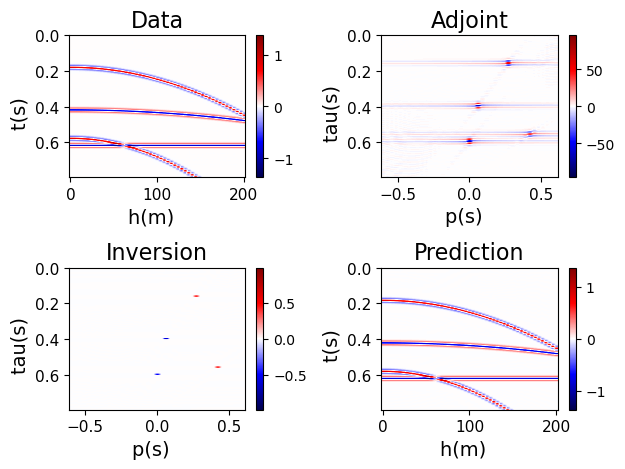

In [45]:

# Inverse problem crime to create a group of parabolic moveout events
dh = 4.
h0 = 0.
h = collect(0:1:50)*dh
dp = 0.03 
p = collect(-20:1:20)*dp
p0 = p[1]

Par_R = Dict(:h=>h,:p=>p,:dt=>0.004,:transf=>"parab")
m = zeros(200,length(p))
   
    m[40,30]= 1.0
   m[100,23]=-1.0
   m[150,21]=-1.0
   m[140,35]=1.0

wave = Ricker(dt=0.004,f0=40)
Par_W = Dict(:wavelet=>wave)
   
# compute the data  d = W R m = L m

 d  = SeisConv(SeisRadon_tx(m,false;Par_R...),false;Par_W...)

# compute the adjoint ma = R'W' d

 ma = SeisRadon_tx(SeisConv(d,true;Par_W...),true; Par_R...);

# L2-L1 solution via IRLS 
P = ones(size(ma))
mirls=zeros(size(ma))
cost=[]
for k=1:4;
    P = sqrt.(abs.(mirls).+0.0001)
    Par_P = Dict(:w=>P)
    u,cost1 =  ConjugateGradients(d, [SeisConv, SeisRadon_tx, WeightingOp],[Par_W,Par_R,Par_P]; Niter=20, mu=0.1, tol=1.0e-15)
               mirls = P.*u
    append!(cost,cost1)
end

# Prediction of the data from Radon panel

dpred = SeisConv(SeisRadon_tx(mirls,false;Par_R...),false;Par_W...);

figure(1);close("all")

subplot(221); SeisPlotTX(d,    dy=0.004, ox=h0, dx=dh, cmap="seismic",fignum=1,pclip=100, xlabel="h(m)", ylabel="t(s)", title="Data");colorbar()

subplot(222); SeisPlotTX(ma,   dy=0.004, ox=p0, dx=dp, cmap="seismic",fignum=1,pclip=100, xlabel="p(s)", ylabel="tau(s)",title="Adjoint");colorbar()

subplot(223); SeisPlotTX(mirls,  dy=0.004, ox=p0, dx=dp, cmap="seismic",fignum=1,pclip=100, xlabel="p(s)", ylabel="tau(s)", title="Inversion");colorbar()

subplot(224); SeisPlotTX(dpred,dy=0.004, ox=h0, dx=dh, cmap="seismic",fignum=1,pclip=100, xlabel="h(m)", ylabel="t(s)", title="Prediction");colorbar()

tight_layout()
savefig("./figs/parab_radon_irls.png")
gcf()

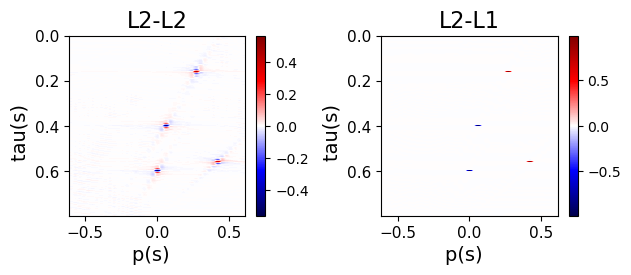

In [46]:


# L2-L2 solution via CGLS 

mcgls,cost =  ConjugateGradients(d, [SeisConv, SeisRadon_tx],[Par_W,Par_R]; Niter=20, mu=00.1, tol=1.0e-5)

figure(2);close("all")
subplot(221); SeisPlotTX(mcgls, dy=0.004, ox=p0, dx=dp, cmap="seismic",fignum=1,pclip=100, xlabel="p(s)", ylabel="tau(s)",title="L2-L2");colorbar()
subplot(222); SeisPlotTX(mirls, dy=0.004, ox=p0, dx=dp, cmap="seismic",fignum=1,pclip=100, xlabel="p(s)", ylabel="tau(s)", title="L2-L1");colorbar()


tight_layout()
savefig("./figs/parab_radon_comparison.png")
gcf()


In [95]:
Q = ones(size(d))
P = ones(size(ma))
(nt,nh)=size(d)
de = copy(d)
de[:,20].=0.05*randn(nt).^3
de[:,24].=0.05*randn(nt).^3
de[:,10].=0.06*randn(nt).^3

for k = 1:4
Par_P = Dict(:w=>P)
Par_Q = Dict(:w=>Q)
u,cost1 =  ConjugateGradients(Q.*de,[WeightingOp, SeisConv, SeisRadon_tx, WeightingOp],[Par_Q,Par_W,Par_R,Par_P]; Niter=10, mu=0.01, tol=1.0e-15)
           mirls = P.*u
           res = de -  SeisConv(SeisRadon_tx(mirls,false;Par_R...),false;Par_W...)
           Q = 1.0./sqrt.((abs.(res).+0.1))
           P = sqrt.(abs.(mirls).+0.0001)
           append!(cost,cost1)
end

dpred = SeisConv(SeisRadon_tx(mirls,false;Par_R...),false;Par_W...);

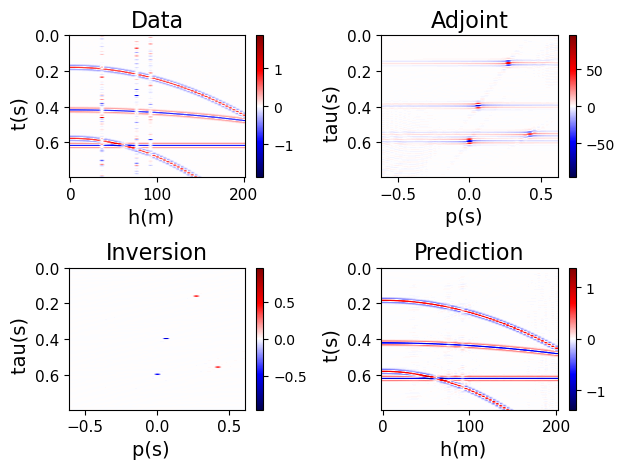

In [96]:
figure(3);close("all")
subplot(221); SeisPlotTX(de,    dy=0.004, ox=h0, dx=dh, cmap="seismic",fignum=1,pclip=100, xlabel="h(m)", ylabel="t(s)", title="Data");colorbar()
subplot(222); SeisPlotTX(ma,    dy=0.004, ox=p0, dx=dp, cmap="seismic",fignum=1,pclip=100, xlabel="p(s)", ylabel="tau(s)",title="Adjoint");colorbar()
subplot(223); SeisPlotTX(mirls, dy=0.004, ox=p0, dx=dp, cmap="seismic",fignum=1,pclip=100, xlabel="p(s)", ylabel="tau(s)", title="Inversion");colorbar()
subplot(224); SeisPlotTX(dpred, dy=0.004, ox=h0, dx=dh, cmap="seismic",fignum=1,pclip=100, xlabel="h(m)", ylabel="t(s)", title="Prediction");colorbar()
tight_layout()
savefig("./figs/parab_radon_irls_robust.png")
gcf()